# Lab7 基于深度学习的细胞类型聚类

> 姓名：王茂增\
> 学号：2113972\
> 专业：计算机科学与技术\
> 代码：https://github.com/mzwangg/MachineLearning

## 研究背景及意义

通过单细胞核糖核酸测序（single-cell adata sequencing，scadata-seq）进行细胞分类是生物医学研究中的重要领域，它在揭示单个细胞水平上的基因表达和功能特征方面发挥着关键作用：

1. **单细胞水平的异质性：** 传统的基因表达研究通常依赖于组织或细胞群体的平均水平，忽略了细胞内和细胞间的异质性。然而，在生物体内，细胞之间存在显著的差异，即使它们属于相同类型。因此，了解单个细胞的基因表达是揭示生物体内细胞异质性的关键。

2. **疾病和发育过程的单细胞解析：** 单细胞adata测序为研究疾病状态和生物发育过程提供了突破口。通过对单个细胞的基因表达进行深入分析，研究人员可以更好地理解不同细胞状态、亚型和转录组变化对疾病的影响以及它们在发育过程中的调控。

3. **细胞类型鉴定与分类：** 利用单细胞adata测序，研究人员可以对复杂组织和器官中的细胞类型进行精准的鉴定和分类。这有助于建立更准确的细胞谱系图，揭示细胞的发育轨迹，同时也为研究人员提供了更多理解疾病发展和治疗的线索。

4. **计算生物学、机器学习、深度学习的应用：** 单细胞adata测序数据的高度复杂性和维度使得其分析需要涉及计算生物学、机器学习甚至深度学习的方法。这包括细胞聚类、细胞亚型标识、差异表达基因分析等，为了从海量数据中提取有意义的生物学信息。

在这个背景下，通过单细胞adata测序进行细胞分类的研究旨在深入理解细胞的多样性和功能，推动疾病研究、治疗策略的个体化定制以及对生物体发育过程的全面认识。这些研究有望为精准医学和个性化治疗提供重要支持，推动生物医学领域的科学发展。

## 方法介绍

本人复现了论文[scDCCA: deep contrastive clustering for single-cell adata-seq data based on auto-encoder network](https://academic.oup.com/bib/article/24/1/bbac625/6984787)，其结构如下所示：

![](pic/frame.png)

该模型主要包含以下模块：

- **数据预处理模块**：
  
    首先对数据进行对数变换。其次，剔除在大于 95% 的细胞中表达值为 0 的基因。第三，计算大小因子，并按大小对数据进行归一化处理。最后，选择 1000 个高变异基因，对特征方差进行过滤。与低变异基因相比，这些高变异基因包含更多的生物信息，对确定细胞类型有重要影响。此外，选择高变异基因除了能降低整体数据噪声外，还能带来计算上的收益。

- **数据扩增模块**： 
  
    首先将预处理后的基因矩阵表示为 X。给定一个输入单元（实例）xi，我们通过在每个视图中屏蔽任意一组随机基因来构建其两个不同的增强视图（$x_i^1$ 和 $x^1_i$）。在这里，每个视图中有 10% 的基因被屏蔽（pmask = 0.1）。在接下来的计算中，这些被屏蔽的基因将被忽略。我们对每个细胞进行数据扩增，得到两个扩增数据（X1 和 X2）。预处理后的数据 X 及其两个增强项（X1 和 X2）是基于 ZINB 的去噪自动编码器的输入，用于执行特征嵌入。

- **去噪自动编码器嵌入模块**：
  
    去噪自动编码器在学习数据表示方面具有强大而鲁棒的能力，因为它可以通过接收带有噪声的输入来恢复原始未损坏的数据点。我们使用去噪自动编码器来学习将输入数据投影到用于聚类的潜在空间的映射函数。具体而言，假设输入的单细胞adata测序数据为：$X=\left[x_1, x_1, \ldots, x_i, \ldots x_n\right] \in R^{m \times n}$，它们首先被用随机高斯噪声$e$损坏，即：
    $$
    \mathrm{X}^{\text {corrupt }}=\mathrm{X}+e
    $$
    随后，定义编码器函数和解码器函数如下：
    $$
    \begin{gathered}
    Z=f_W\left(X^{\text {corrupt }}\right) \\
    X^{\prime}=g_{W^{\prime}}(Z)
    \end{gathered}
    $$
    其中$\mathrm{W}$和$\mathrm{W}^{\prime}$表示函数的学习权重。值得注意的是，去噪自动编码器在学习过程中最小化以下重构损失函数$L$：
    $$
    L\left(X, g_W,\left(f_W\left(X^{\text {corrupt }}\right)\right)\right)
    $$
    为了更好地表征过度稀疏和过度分散的单细胞adata测序数据，引入ZINB分布来帮助自动编码器嵌入高维数据。具体而言，设$x_{i j}$为$X$中细胞$i$的基因$j$的基因表达值。ZINB分布有三个参数，即负二项分布的均值$\left(\mu_{i j}\right)$、离散度$\left(\theta_{i j}\right)$和额外的系数$\left(\pi_{i j}\right)$，表示丢失事件的概率。它可以表示为：

    $$
    \begin{aligned}
    & NB\left(x_{i j} \mid \mu_{i j}, \theta_{i j}\right)=\frac{\Gamma\left(x_{i j}+\theta_{i j}\right)}{x_{i j} ! \Gamma\left(\theta_{i j}\right)}\left(\frac{\theta_{i j}}{\theta_{i j}+\mu_{i j}}\right)^{\theta_{i j}}\left(\frac{\mu_{i j}}{\theta_{i j}+\mu_{i j}}\right)^{x_{i j}} \\
    & ZINB\left(x_{i j} \mid \pi_{i j}, \mu_{i j}, \theta_{i j}\right)=\pi_{i j} \delta_0\left(x_{i j}\right)+\left(1-\pi_{i j}\right) N B\left(x_{i j} \mid \mu_{i j}, \theta_{i j}\right)
    \end{aligned}
    $$

    然后，自动编码器通过最小化以下损失函数来重构数据，该函数是所有数据点的负对数似然的和：
    
    $$
    L_{\text {ZINB }}=\sum_{i j}-\log \left(ZINB\left(x_{i j} \mid \pi_{i j}, \mu_{i j}, \theta_{i j}\right)\right)
    $$

- **双对比学习模块**：
  
    为了捕获细胞之间的关系，scDCCA将双对比学习模块纳入其中。这种双对比学习范式有助于模型捕获样本和簇的更具辨别性的特征，从而实现簇内紧密性和簇间分离性。具体而言，给定一个大小为$N$的小批量，SCDCCA首先对每个实例执行数据增强，以生成$2N$个数据样本$\left\{x_1^1, x_2^1, \ldots, x_N^1, x_1^2, x_2^2, \ldots, x_N^2\right\}$。对于特定样本$x_i$，总共有$2N-1$对。在这些对中，我们将两个增强$\left\{x_i^1, x_i^2\right\}$视为正样本，而其他$2N-2$对为负样本。然后，我们通过去噪ZINB模型自动编码器将增强数据映射到潜在空间，并在该潜在空间上进行实例级对比学习。实例级对比学习通过最小化实例级对比来提取样本的辨别性特征，其中$H(Y)$是簇分配概率的熵，可以通过下列式子计算计算：
    $$
    H(Y)=-\sum_{i=1}^M\left[P\left(\hat{y_i^1}\right) \log P\left(\hat{y_i^2}\right)+P\left(\hat{y_i^2}\right) \log P\left(\hat{y_i^2}\right)\right]
    $$
    簇分配概率可以计算为：
    $$
    P\left(\hat{y_i^1}\right)=\frac{\sum_{t=1}^N Y_t^1}{\left\|Y^1\right\|_1}
    $$

- **聚类模块**：
  
    我们首先通过Student's t分布测量嵌入点$z_i$和簇中心$\mu_j$之间的相似性，表示样本$i$的软分配。可以通过以下计算：
    $$
    q_j=\frac{\left(1+\left\|z_i-\mu_j\right\|^2 / \alpha\right)^{-\frac{\mu+1}{2}}}{\sum_j\left(1+\left\|z_i-\mu_j\right\|^2 / \alpha\right)^{-\frac{-4}{2}}}
    $$
    其中$z_1$是$x_i$的嵌入表示，$\alpha$是Student's t分布的自由度（这里我们设置$\alpha=1$）。根据$q_y$，可以计算辅助分布$p y$：
    $$
    p_{i j}=\frac{q_j^2 / f_j}{\sum_j q_j^2 / f_j}
    $$
    其中$f_j=\sum_i q_j$是软簇频率。然后，聚类损失定义为软分配$q_i$和目标分布$p_i$之间的KL散度，可以通过以下计算：
    $$
    L_{\text {dec }}=K L(P \mid Q)=\sum_i \sum_j p_{i j} \log \frac{p_{i j}}{q_{i j}}
    $$

## 库文件及全局设置

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import warnings
import pandas as pd
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.cluster import KMeans
import torch.nn.functional as F
from tqdm import tqdm
import sys
warnings.filterwarnings('ignore')

c:\Users\86152\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GENE_NUM = 2000
CYCLE_NUM = 3
PRETRAIN_EPOCH = 20
TRAIN_EPOCH = 50
WARMUP_RATE = 0.5

h5ad_path1 = 'data/dataset1.h5ad'
data_path1 = 'data/dataset1.txt'
label_path1 = 'data/dataset1_labels.txt'
pretrain_path1 = 'model/dataset1_pretrain_param.pth'
model_path1 = 'model/dataset1_param.pth'
result_path1 = 'data/dataset1_result.csv'

h5ad_path2 = 'data/dataset2.h5ad'
data_path2 = 'data/dataset2.txt'
label_path2 = 'data/dataset2_labels.txt'
pretrain_path2 = 'model/dataset2_pretrain_param.pth'
model_path2 = 'model/dataset2_param.pth'
result_path2 = 'data/dataset2_result.txt'

## 模型建立

### 损失函数

`InstanceLoss`定义了一个名为 `InstanceLoss` 的损失函数类，该类继承自 PyTorch 的 `nn.Module` 类。在类的初始化函数中，设置了批大小和温度，并创建了相关样本对的掩码、交叉熵损失函数。类中包含了前向传播函数 `forward` 和用于创建相关样本对掩码的函数 `mask_correlated_samples`。前向传播函数计算了两个输入张量的余弦相似度损失，提取了正样本和负样本，并通过交叉熵损失函数计算最终的损失值。

`ClusterLoss`定义了一个名为 `ClusterLoss` 的损失函数类，继承自 PyTorch 的 `nn.Module` 类。在初始化函数中，设定了类别数、温度参数、相关样本对的掩码、交叉熵损失函数和余弦相似度计算函数。类包含了一个用于生成相关样本对掩码的方法和一个用于前向传播的方法。前向传播方法计算了输入向量的负熵损失，将输入向量拼接并计算余弦相似度，提取正样本和负样本，最后通过交叉熵损失函数计算总体损失。

In [3]:
class InstanceLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(InstanceLoss, self).__init__()
        # 初始化批大小和温度
        self.batch_size = batch_size
        self.temperature = temperature

        # 创建相关样本对的掩码
        self.mask = self.mask_correlated_samples(batch_size)
        # 交叉熵损失函数
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        # 创建全1矩阵
        mask = torch.ones((N, N))
        # 将对角线元素设为0
        mask = mask.fill_diagonal_(0)
        # 设置相关样本对应位置为0
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        # 转换为布尔类型掩码
        mask = mask.bool()
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size
        # 拼接输入张量
        z = torch.cat((z_i, z_j), dim=0)

        # 计算余弦相似度
        sim = torch.matmul(z, z.T) / self.temperature
        # 提取正样本和负样本
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        # 构建标签和 logits
        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        # 计算损失
        loss = self.criterion(logits, labels)
        loss /= N

        return loss


class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature):
        # 定义ClusterLoss这个类的基本参数和方法
        super(ClusterLoss, self).__init__()
        self.class_num = class_num  # 类别数目，例如类别数为10
        self.temperature = temperature  # 温度参数，默认为1.0
        self.mask = self.mask_correlated_clusters(class_num)  # 定义mask的方式
        self.criterion = nn.CrossEntropyLoss(reduction="sum")  # 定义损失标准采用交叉熵
        self.similarity_f = nn.CosineSimilarity(dim=2)  # 定义相似性采用余弦相似度

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))  # 生成(N, N)的全1矩阵
        mask = mask.fill_diagonal_(0)  # 对角线元素置0
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()  # 转成bool型变量，即其中的1变成True
        return mask

    def forward(self, c_i, c_j):
        ## 对每一批，c_i是256个10维的向量，
        p_i = c_i.sum(0).view(-1)  # 把这一批256个求和，得到一个总的p_i，是一个10维的向量
        p_i /= p_i.sum()  # p_i.sum()=256，所以p_i这里是求平均，是一个10维的向量
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()  # log(p_i)求得是以e为底的ln(p_i),
        
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()  ## 转置，变成10*256的
        c_j = c_j.t()  # 转置，变成10*256的
        N = 2 * self.class_num  # N=20
        c = torch.cat((c_i, c_j), dim=0)  ## 拼接，变成20*256的

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature  # 20*20的
        sim_i_j = torch.diag(sim, self.class_num)  # 取矩阵的对角线元素
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss

### 性能评估

`cluster_acc`实现了计算**聚类准确率**的功能。首先，通过断言确保预测簇的大小与真实标签的大小相同。然后，确定簇的数量，假设簇的标签是从0开始的整数，以便初始化混淆矩阵。接下来，通过遍历真实标签和预测簇的对应关系，填充混淆矩阵。使用linear_sum_assignment函数来找到混淆矩阵的最佳匹配，该函数使用匈牙利算法进行最小权重匹配。最后，通过计算正确匹配的样本数量占总样本数量的比例来得到聚类准确率。

`evaluate`通过调用`cluster_acc`和`sklearn`中的库函数`adjusted_rand_score`计算分类的ARI指标并返回。

In [4]:
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.optimize import linear_sum_assignment

def cluster_acc(y_true, y_pred):
    # 确保预测簇的大小与真实标签的大小相同
    assert y_pred.size == y_true.size

    # 获取簇的数量，这里假设簇的标签是从0开始的整数
    D = max(y_pred.max(), y_true.max()) + 1

    # 初始化并填充混淆矩阵
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # 使用匈牙利算法找到最佳匹配， 计算准确率
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    accuracy = sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

    return accuracy

def evaluate(y_true, y_pred):
    acc= cluster_acc(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    return acc, ari

### 神经网络层结构

- `ZINBLoss` 类实现了负二项分布损失函数，用于模型的训练过程，其中包括负二项分布的对数似然计算和可选的 ridge 惩罚。

- `GaussianNoise` 类实现了在训练时向输入添加高斯噪音的功能。

- `MeanAct` 类和 `DispAct` 类分别实现了均值和离散度的激活函数，使用指数函数和 softplus 函数，并在结果中进行了范围限制。

In [5]:
class ZINBLoss(nn.Module):
    def __init__(self):
        super(ZINBLoss, self).__init__()

    def forward(self, x, mean, disp, pi, scale_factor=1.0, ridge_lambda=0.0):
        eps = 1e-10
        scale_factor = scale_factor[:, None]  # 扩展维度，用于与 mean 对应元素相乘
        mean = mean * scale_factor  # 将均值乘以 scale_factor

        # 计算负二项分布的对数似然
        t1 = torch.lgamma(disp+eps) + torch.lgamma(x+1.0) - torch.lgamma(x+disp+eps)
        t2 = (disp+x) * torch.log(1.0 + (mean/(disp+eps))) + (x * (torch.log(disp+eps) - torch.log(mean+eps)))
        nb_final = t1 + t2

        nb_case = nb_final - torch.log(1.0-pi+eps)  # 非零计数的情况
        zero_nb = torch.pow(disp/(disp+mean+eps), disp)  # 零计数的情况
        zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)  # 计算零计数的对数似然
        result = torch.where(torch.le(x, 1e-8), zero_case, nb_case)  # 根据 x 的大小选择计数情况

        if ridge_lambda > 0:
            ridge = ridge_lambda*torch.square(pi)  # 添加 ridge 惩罚
            result += ridge

        result = torch.mean(result)  # 求平均
        return result

class GaussianNoise(nn.Module):
    def __init__(self, sigma=0):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma
    
    def forward(self, x):
        if self.training:
            x = x + self.sigma * torch.randn_like(x)  # 训练时添加高斯噪音
        return x

class MeanAct(nn.Module):
    def __init__(self):
        super(MeanAct, self).__init__()

    def forward(self, x):
        return torch.clamp(torch.exp(x), min=1e-5, max=1e6)  # 使用指数函数并限制范围

class DispAct(nn.Module):
    def __init__(self):
        super(DispAct, self).__init__()

    def forward(self, x):
        return torch.clamp(F.softplus(x), min=1e-4, max=1e4)  # 使用 softplus 函数并限制范围

### 模型建立

- `buildNetwork` 函数实现了一个简单的前馈神经网络的构建，通过输入层、隐藏层（多层线性层和ReLU激活函数），最终形成一个序列化的神经网络。函数参数 `layers` 是一个列表，表示网络的每一层的维度，函数返回一个包含多个线性层和ReLU激活函数的序列化网络。

- `__init__` 接收多个超参数，包括输入维度 `input_dim`、聚类簇数 `n_clusters`、隐藏层维度 `z_dim` 等。在构造函数中初始化了模型的各个部分，包括去噪自动编码器的编码器和解码器，质心坐标 `mu`，各个投影模块等。

  1. `encoder` 是去噪自动编码器的编码器部分，通过调用 `buildNetwork` 构建一个前馈神经网络，其中输入层维度是 `input_dim`，隐藏层维度由 `encodeLayer` 指定。

  2. `decoder` 和 `decoder1` 是去噪自动编码器的两个解码器部分，也通过 `buildNetwork` 构建，其中输入层维度是 `z_dim`，隐藏层维度由 `decodeLayer` 指定。

  3. `_enc_mu` 是编码器输出到潜变量 `z` 的线性层。

  4. `_dec_mean`、`_dec_disp`、`_dec_pi` 分别是解码器输出均值、离散度和 Pi 参数的线性层。

  5. `instance_projector` 是实例投影模块，通过两个线性层和ReLU激活函数构成。

  6. `cluster_projector` 是聚类投影模块，通过一个线性层和Softmax激活函数构成。

  7. 初始化模型的温度和正则化参数。

  8. 初始化质心坐标参数 `mu`。

  9.  初始化 ZINB 损失函数。

  10. `to(device)` 将模型移至指定的设备。

- `soft_assign` 函数实现了对输入 `z` 进行软分配（soft assignment）的操作，即使用学生分布度量输入 `z` 与模型的聚类中心 `self.mu` 之间的相似度。通过计算欧氏距离的平方，然后通过学生分布的形式进行转化，得到每个数据点属于各个簇的软分配概率，最后返回一个大小为 (num_samples, num_clusters) 的软分配矩阵 `q`。

- `target_distribution` 函数接收软分配概率矩阵 `q`，并计算目标分布矩阵 `p`，其中每一列表示每个簇的概率，通过对 `q` 的平方项进行归一化得到。最后返回一个与 `q` 相同大小的目标分布矩阵 `p`。

- `x_drop` 函数实现了对输入数据 `x` 进行随机 dropout 操作。对于每个样本的每个维度，以概率 `p` 进行 dropout 操作，将对应位置的元素置为零。返回一个与输入相同大小的新数据 `new_x`。

- `forward` 函数是整个模型的前向传播过程，用于预训练模型。首先，对输入数据 `x` 加入服从标准正态分布的噪声，然后通过编码器获得中间表示 `z`，之后通过解码器还原得到重构数据。同时，使用加了噪声的输入计算 `_mean`、`_disp`、`_pi`，并直接使用原始输入计算 `z0` 和软分配 `q`。函数返回编码结果 `z0`、软分配概率 `q`、以及解码得到的 `_mean`、`_disp`、`_pi` 这些中间变量。

- `calc_ssl_lossv1` 函数实现了基于实例对比的损失计算。它接收两个输入 `x1` 和 `x2`，将它们分别通过模型的编码层得到相应的隐层表示 `z1` 和 `z2`，然后使用 `InstanceLoss` 类计算实例对比损失，并返回这个损失值。

- `calc_ssl_lossv2` 函数计算对比聚类损失。同样，它接收两个输入 `x1` 和 `x2`，通过模型的编码层分别得到 `z1` 和 `z2`，然后通过聚类投影层将其映射为低维表示 `c1` 和 `c2`，最后使用 `ClusterLoss` 类计算对比聚类损失，并返回损失值。

- `encodeBatch` 函数对输入数据 `X` 进行编码，每次处理一个批次的数据以避免超显存。它遍历数据集，将每个批次的数据通过模型的编码层得到相应的嵌入向量，然后将所有批次的嵌入向量拼接起来，返回一个包含所有数据点编码结果的张量。

- `cluster_loss` 函数计算聚类 KL 散度损失。接收两个分布 `p` 和 `q`，通过 Kullback-Leibler 散度计算它们的损失值，最后返回加权的 KL 散度损失，权重为 `gamma`。

- `pretrain_autoencoder`定义了一个自编码器的预训练方法。在给定原始数据 `x`、处理后的数据 `X_raw` 和大小因子 `size_factor` 的情况下，通过对模型进行预训练，优化参数以最小化 ZINB 损失和自监督学习损失。预训练采用 AdamW 优化器进行梯度下降，每轮迭代中都对整个数据集进行批量训练。在每个批次中，通过数据增广和自监督学习的方式，对加了噪声的 x 进行编码解码，计算 ZINB 损失和自监督学习损失，然后将两者相加得到整体损失。最后，通过梯度反向传播和优化器更新模型参数。如果设置了 `ae_save` 为 `True`，则保存训练后的模型参数到指定的文件路径。

- `fit`实现了一个深度学习模型的训练过程，整个过程中，模型通过编码输入数据生成隐层表示，计算软标签和目标分布，同时进行对比聚类、聚类 KL 和重构 ZINB 三个损失的优化，最终选择性能最好的模型，主要包括以下几个步骤：

  1. 将模型移至 GPU 进行加速。

  2. 使用 Adadelta 优化器进行模型参数的优化，学习率为 lr，rho 为 0.95。

  3. 使用 kmeans 算法初始化聚类中心。

  4. 训练模型多轮（num_epochs），每轮中进行以下步骤：

      a. 计算软标签 q 和目标分布 p。

      b. 根据软标签 q 计算预测标签，评估聚类性能。

      c. 如果当前 ARI 比最优 ARI 大，则保存模型。

      d. 训练 1 轮用于聚类损失，计算总的训练损失，包括聚类 KL 损失、重构 ZINB 损失和对比聚类损失。

      e. 输出每个损失的平均值。

  5. 选择 ARI 指标最大的一轮对应的预测标签作为最终结果，返回最优预测标签的评估结果。

In [6]:
def buildNetwork(layers):
    net = []
    for i in range(1, len(layers)):
        net.append(nn.Linear(layers[i - 1], layers[i]))
        net.append(nn.ReLU())
    return nn.Sequential(*net)

class MyModel(nn.Module):
    def __init__(self, input_dim, n_clusters, z_dim=32, encodeLayer=[], decodeLayer=[],
                activation="relu", sigma=2.5, alpha=1.0, gamma=1.0, i_temp=0.5, c_temp=1.0, i_reg=0.5, c_reg=0.2,
                feature_dim=32, device='cuda:0'):
        super(MyModel, self).__init__()
        # 初始化模型的超参数和架构
        self.z_dim = z_dim
        self.n_clusters = n_clusters
        self.activation = activation
        self.sigma = sigma
        self.alpha = alpha
        self.gamma = gamma

        # 实现去噪自动编码器嵌入模块
        self.encoder = buildNetwork([input_dim] + encodeLayer)  # 2000-256-64
        self.decoder = buildNetwork([z_dim] + decodeLayer)  # 32-64-256
        self.decoder1 = buildNetwork([z_dim] + decodeLayer)  # 32-64-256

        self._enc_mu = nn.Linear(encodeLayer[-1], z_dim)  # 64-32
        self._dec_mean = nn.Sequential(nn.Linear(decodeLayer[-1], input_dim), MeanAct())  ## 256-2000
        self._dec_disp = nn.Sequential(nn.Linear(decodeLayer[-1], input_dim), DispAct())  ## 256-2000
        self._dec_pi = nn.Sequential(nn.Linear(decodeLayer[-1], input_dim), nn.Sigmoid())  ## 256-2000

        # 初始化温度和正则化参数
        self.i_temp = i_temp
        self.c_temp = c_temp
        self.i_reg = i_reg
        self.c_reg = c_reg

        # 实例投影和聚类投影模块
        self.instance_projector = nn.Sequential(  ## 实例投影
            nn.Linear(z_dim, z_dim),  # 32-32
            nn.ReLU(),
            nn.Linear(z_dim, feature_dim))  # 32-2000

        self.cluster_projector = nn.Sequential(  ### 聚类投影，z_dim维投影到n_clusters维
            nn.Linear(z_dim, n_clusters),  ## 32-10
            nn.Softmax(dim=1))

        # 初始化质心坐标参数
        self.mu = nn.Parameter(torch.Tensor(n_clusters, z_dim))  # 生成一个10*32的质心坐标，即每个簇的坐标都是32维
        # 初始化 ZINB 损失函数
        self.zinb_loss = ZINBLoss()
        self.to(device)

    def soft_assign(self, z):  ##算z所属的软标签，即用学生分布度量z与self.mu的相似度
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.mu) ** 2, dim=2) / self.alpha)  #对于每一个cell都有一个10维度的q,因为属于每个簇的概率不同
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q  #对于每一个cell都有一个10维度的q,因为属于每个簇的概率不同，所以q是268*10的矩阵

    def target_distribution(self, q):
        p = q ** 2 / q.sum(0)
        return (p.t() / p.sum(1)).t()

    def x_drop(self, x, p=0.2):
        mask_list = [torch.rand(x.shape[1]) < p for _ in range(x.shape[0])]
        mask = torch.vstack(mask_list)
        new_x = x.clone()
        new_x[mask] = 0.0
        return new_x

    def forward(self, x):  #作用是对数据进行预训练，得到相应的中间变量，z0, q是用原始的x得到的，_mean, _disp, _pi是用加了噪声的x得到的
        h = self.encoder(x + torch.randn_like(x) * self.sigma)  ##将输入加噪声以后进行编码，2000-256-64
        z = self._enc_mu(h)  ##64-32
        h = self.decoder(z)  ##32-64-256

        h1 = self.decoder1(z)  ##32-64-256
        h = (h1 + h) / 2  #求平均是为了减小波动

        _mean = self._dec_mean(h)
        _disp = self._dec_disp(h)
        _pi = self._dec_pi(h)

        h0 = self.encoder(x)  ##将输入直接进行编码，2000-256-64
        z0 = self._enc_mu(h0)  ##64-32
        q = self.soft_assign(z0)  #直接对隐藏层z0求软分配，度量的是z0和self.mu的相似性
        return z0, q, _mean, _disp, _pi

    def calc_ssl_lossv1(self, x1, x2):
        z1, _, _, _, _ = self.forward(x1)  #将x1送到编码层2000-256-64-32得到z1
        z2, _, _, _, _ = self.forward(x2)  ##将x2送到编码层2000-256-64-32得到z2

        instance_loss = InstanceLoss(x1.shape[0], self.i_temp)  #x1.shape[0]=256,self.i_temp=0.5,算instance_loss
        return instance_loss.forward(z1, z2)  #返回instance_loss

    def calc_ssl_lossv2(self, x1, x2):  #计算对比过程的聚类损失，2000维
        z1, _, _, _, _ = self.forward(x1)
        z2, _, _, _, _ = self.forward(x2)  #32维
        c1 = self.cluster_projector(z1)
        c2 = self.cluster_projector(z2)  ###10维
        cluster_loss = ClusterLoss(self.n_clusters, self.c_temp)  #定义cluster_loss的计算用ClusterLoss函数，具体去看这个函数
        return cluster_loss.forward(c1, c2)

    def encodeBatch(self, X, batch_size=256):  ##encodeBatch的作用是对输入进行编码得到编码的嵌入向量，输入就是原始的x，
        # 每次只处理一个批次的数据，将数据按批次处理，避免超显存
        self.cuda()
        encoded = []  #encoded是一个空列表
        num = X.shape[0]  ##num=268即细胞数目
        num_batch = int(math.ceil(1.0 * X.shape[0] / batch_size))  #每批次256，算算要多少批，这里是268/256=2
        for batch_idx in range(num_batch):  #对每一批
            xbatch = X[batch_idx * batch_size: min((batch_idx + 1) * batch_size, num)]  #取该批次的数据
            inputs = Variable(xbatch)
            z, _, _, _, _ = self.forward(inputs)  #对数据进行编码2000-256-64-32得到32维的z
            encoded.append(z.data)  #将这256个32维的数据存在encoded列表中，作为它的一个元素，回到for继续，直到所有批次存完，最后encoded列表中存放的是所有细胞的32维的编码

        encoded = torch.cat(encoded, dim=0)  #将encoded列表的所有元素拼接起来，成为一个(num,32)的tensor
        return encoded

    def cluster_loss(self, p, q):
        def kld(target, pred):
            return torch.mean(
                torch.sum(target * torch.log(target / (pred + 1e-6)), dim=-1))  ##这里求了均值，所以后面会* len(inputs)

        kldloss = kld(p, q)
        return self.gamma * kldloss  ##self.gamma=1.0

    def pretrain_autoencoder(self, x, X_raw, size_factor, batch_size=256, lr=0.001, epochs=400, ae_save=True,
                            ae_weights='AE_weights.pth.tar'):
        self.cuda()  # 将模型移至 GPU
        dataset = TensorDataset(torch.Tensor(x), torch.Tensor(X_raw), torch.Tensor(size_factor))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # 创建数据加载器
        
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)  # 使用AdamW优化器
        validbar = tqdm(range(epochs), file=sys.stdout )
        for epoch in validbar:
            for batch_idx, (x_batch, x_raw_batch, sf_batch) in enumerate(dataloader):
                x_tensor = Variable(x_batch).cuda()  # 数据送给 GPU
                x_raw_tensor = Variable(x_raw_batch).cuda()
                sf_tensor = Variable(sf_batch).cuda()

                # 进入模型的前向传播，输出三个参数，这里只关心后面三个参数，所以实际上是对加了噪声的 x 进行编码解码后得到的结果
                _, _, mean_tensor, disp_tensor, pi_tensor = self.forward(x_tensor)

                # 计算 ZINB 损失
                zinb_loss = self.zinb_loss(x=x_raw_tensor, mean=mean_tensor, disp=disp_tensor, pi=pi_tensor,
                                        scale_factor=sf_tensor)

                # 数据增广
                x1 = self.x_drop(x_tensor, p=0.2)
                x2 = self.x_drop(x_tensor, p=0.2)

                # 计算自监督学习损失
                instance_loss = self.calc_ssl_lossv1(x1, x2)
                instance_loss = self.i_reg * instance_loss

                # 整体损失包括 ZINB 损失和自监督学习损失
                loss = zinb_loss + instance_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                validbar.desc = 'Pretrain epoch [{}/{}], ZINB loss:{:.4f}, Instance loss:{:.4f}'.format(epoch + 1,epochs,
                                                                                        zinb_loss.item(),
                                                                                        instance_loss.item())

        if ae_save:
            torch.save(self.state_dict(), ae_weights)


    def fit(self, X, X_raw, sf, y=None, lr=1., batch_size=256, num_epochs=10, save_path='', warmup_rate = 0.7):
        self.cuda()  # 将模型移至 GPU
        X = torch.tensor(X).cuda()
        X_raw = torch.tensor(X_raw).cuda()
        sf = torch.tensor(sf).cuda()
        optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, self.parameters()), lr=lr, rho=.95)  # 使用Adadelta优化器

        kmeans = KMeans(self.n_clusters, n_init=20)  # 定义 kmeans 聚类
        data = self.encodeBatch(X)  # 获取编码后的数据
        self.y_pred = kmeans.fit_predict(data.data.cpu().numpy())  # 用 kmeans 聚类得到预测标签
        self.y_pred_last = self.y_pred  # 备份一下预测标签
        self.mu.data.copy_(torch.Tensor(kmeans.cluster_centers_))  # 备份 kmeans 的聚类中心

        self.train()
        num = X.shape[0]  # 数据点数目
        num_batch = int(math.ceil(1.0 * X.shape[0] / batch_size))  # 计算批次数目
        best_pred = []  # 保存最优预测
        best_loss = np.inf  # 初始化最优loss为正无穷
        validbar = tqdm(range(num_epochs), file=sys.stdout)
        for epoch in validbar:
            # 更新目标分布 p
            latent = self.encodeBatch(X)  # 获取编码后的数据
            q = self.soft_assign(latent)  # 计算软标签 q
            p = self.target_distribution(q).data  # 计算目标分布 p

            # 评估聚类性能
            self.y_pred = torch.argmax(q, dim=1).data.cpu().numpy()  # 根据软标签 q 得到预测标签

            # 训练 1 轮用于聚类损失
            train_loss = 0.0  # 初始化总的训练损失为 0
            recon_loss_val = 0.0  # 初始化重构损失为 0
            cluster_loss_val = 0.0  # 初始化聚类 KL 损失为 0
            c_loss_val = 0.0  # 初始化对比聚类损失为 0

            # 遍历每个批次进行训练
            for batch_idx in range(num_batch):
                xbatch = X[batch_idx * batch_size: min((batch_idx + 1) * batch_size, num)]  # 取当前批次的输入数据
                xrawbatch = X_raw[batch_idx * batch_size: min((batch_idx + 1) * batch_size, num)]  # 取当前批次的原始输入数据
                sfbatch = sf[batch_idx * batch_size: min((batch_idx + 1) * batch_size, num)]  # 取当前批次的大小因子数据
                pbatch = p[batch_idx * batch_size: min((batch_idx + 1) * batch_size, num)]  # 从目标分布中取当前批次的数据

                optimizer.zero_grad()  # 梯度清零

                inputs = Variable(xbatch)
                rawinputs = Variable(xrawbatch)
                sfinputs = Variable(sfbatch)
                target = Variable(pbatch)

                z, qbatch, meanbatch, dispbatch, pibatch = self.forward(inputs)  # 对该批次的输入进行编码

                inputs1 = self.x_drop(inputs, p=0.2)
                inputs2 = self.x_drop(inputs, p=0.2)
                c_loss = self.calc_ssl_lossv2(inputs1, inputs2)  # 计算对比聚类损失
                c_loss = self.c_reg * c_loss  # 对比损失乘以系数

                cluster_loss = self.cluster_loss(target, qbatch)  # 计算聚类 KL 损失
                recon_loss = self.zinb_loss(rawinputs, meanbatch, dispbatch, pibatch, sfinputs)  # 计算重构 ZINB 损失
                loss = cluster_loss + recon_loss + c_loss  # 总的训练损失是 KL 聚类损失 + 重构损失 + 对比聚类损失

                loss.backward()  # 反向传播
                optimizer.step()  # 更新模型参数

                # 汇总每个批次的损失
                cluster_loss_val += cluster_loss.data * len(inputs)  # 因为再算每一个损失的时候算的都是平均值，所以乘以个数
                recon_loss_val += recon_loss.data * len(inputs)
                c_loss_val += c_loss.data * len(inputs)
                train_loss = cluster_loss_val + recon_loss_val + c_loss_val  # 总的训练损失是 KL 聚类损失 + 重构损失 + 对比聚类损失

            # 输出总的损失
            validbar.desc = "#Epoch %3d: Total: %.4f Clustering Loss: %.4f ZINB Loss: %.4f C Loss: %.4f" % (
                epoch + 1, train_loss / num, cluster_loss_val / num, recon_loss_val / num,
                c_loss_val / num)

            if epoch>=warmup_rate * num_epochs and best_loss > train_loss:  # 如果当前 ARI 比最优 ARI 大，更新最优 ARI 和保存模型
                best_loss = train_loss
                best_pred = self.y_pred
                torch.save({'latent': latent, 'q': q, 'p': p}, save_path)  # 保存编码结果
                latent = latent.cpu().numpy()  # 转换为 numpy 数组

            # if(y is not None):
            #     acc, ari = evaluate(y, self.y_pred)
            #     print(ari)


        return best_pred, best_loss/num


## 处理dataset2

下列代码首先通过`ad.read_h5ad`读取HDF5文件中的数据集，然后使用Scanpy库进行基因过滤、log1p变换以及高变基因的识别。接着，将稀疏矩阵转换为密集矩阵，并将数据保存为CSV文件。最后，处理标签信息，将细胞类型映射为数字编码，并保存为另一个CSV文件。整个过程涉及数据预处理、转换和保存，以便后续在深度学习任务中使用。

In [ ]:
# 读取数据集
adata = ad.read_h5ad(h5ad_path2)  # 从h5ad文件读取数据
sc.pp.filter_genes(adata, min_cells=adata.X.shape[0] * 0.05)  # 过滤基因，保留至少占总细胞数5%的基因
sc.pp.log1p(adata)  # 对数据进行log1p变换
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=GENE_NUM)  # 识别高变基因
adata = adata[:, adata.var['highly_variable']]  # 保留高变基因的数据

# 将稀疏矩阵转换为密集矩阵，并保存为CSV文件
x = adata.X.toarray()
np.savetxt(data_path2, x, delimiter=',')

# 处理标签
y = pd.Series(adata.obs.cell_type)  # 获取细胞类型标签
lab = y.unique().tolist()
print(len(lab), lab)

# 标签映射为数字编码
ind = list(range(0, len(lab)))
mapping = {j: i for i, j in zip(ind, lab)}
y = y.map(mapping).to_numpy()

# 保存标签为CSV文件
np.savetxt(label_path2, y, fmt='%d')


1. 创建 AnnData 对象 `adata` 并将原始数据存储在 `adata.raw` 中。
2. 对每个细胞的表达量进行标准化，并计算并存储大小因子。
3. 初始化用于评估指标的数组，包括准确率（acc）、ARI（ari）和损失（loss）。
4. 循环进行聚类评估（`CYCLE_NUM` 次）：
    a. 初始化并训练模型 `MyModel`，使用预训练自动编码器。
    b. 进行最终的聚类和评估，得到预测结果 `pred` 和损失值 `loss`。
    c. 计算并输出准确率和ARI。
    d. 将结果添加到评估指标数组中。
5. 找到损失最小的一次循环，并输出最优的损失、准确率和ARI。
6. 将最优预测结果保存到文件。

In [27]:
# 将原始数据存储在 adata.raw 中
adata = sc.AnnData(x)
adata.raw = adata.copy()

# 标准化每个细胞的表达量
sc.pp.normalize_per_cell(adata)
# 计算并存储大小因子
adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)

# 初始化评估指标的数组
n_clusters = len(lab)
accc, arii, losss = np.array([]), np.array([]), np.array([])
preds = []

# 循环进行聚类评估
for i in range(CYCLE_NUM):
    print("第%d/%d次循环" % (i + 1, CYCLE_NUM))  # 修正此行的格式化字符串

    # 初始化并训练模型
    model = MyModel(
        input_dim=adata.n_vars,
        n_clusters=n_clusters,
        encodeLayer=[256, 64],
        decodeLayer=[64, 256])

    model.pretrain_autoencoder(
        x=adata.X,
        X_raw=adata.raw.X,
        size_factor=adata.obs.size_factors,
        batch_size=1024,
        epochs=PRETRAIN_EPOCH,
        ae_weights=pretrain_path2)

    # 进行最终的聚类和评估
    pred, loss = model.fit(
        X=adata.X,
        X_raw=adata.raw.X,
        sf=adata.obs.size_factors,
        y=y,
        lr=1,
        batch_size=1024,
        num_epochs=TRAIN_EPOCH,
        save_path=model_path2,
        warmup_rate=WARMUP_RATE)
    
    acc, ari = evaluate(y, pred)
    print("acc={},ari={}, loss={:.4f}".format(acc, ari, loss))
    # 将结果添加到评估指标数组中
    accc = np.append(accc, acc)
    arii = np.append(arii, ari)
    losss = np.append(losss, loss.cpu())
    preds.append(pred)


best_index = np.argmin(losss)
print(losss)
print('optimal:LOSS= {:.4f}'.format(losss[best_index]))
print('optimal:ACC= {:.4f}'.format(accc[best_index]))
print('optimal:ARI= {:.4f}'.format(arii[best_index]))
np.savetxt(result_path2, np.array(preds[best_index]), fmt='%d')
print("result save successfully!")


第1/3次循环
Pretrain epoch [20/20], ZINB loss:0.3705, Instance loss:0.1982: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]
#Epoch  50: Total: 1.3686 Clustering Loss: 0.3797 ZINB Loss: 0.3687 C Loss: 0.6203: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]
acc=0.6360174102285092,ari=0.5355150821661967, loss=1.2735
第2/3次循环
Pretrain epoch [20/20], ZINB loss:0.3794, Instance loss:0.1975: 100%|██████████| 20/20 [00:44<00:00,  2.23s/it]
#Epoch  50: Total: 1.2715 Clustering Loss: 0.2824 ZINB Loss: 0.3699 C Loss: 0.6192: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]
acc=0.6626768226332971,ari=0.5946183187196519, loss=1.2715
第3/3次循环
Pretrain epoch [20/20], ZINB loss:0.3756, Instance loss:0.1906: 100%|██████████| 20/20 [00:44<00:00,  2.22s/it]
#Epoch  50: Total: 1.3838 Clustering Loss: 0.3964 ZINB Loss: 0.3691 C Loss: 0.6183: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]
acc=0.650272034820457,ari=0.5448495028527848, loss=1.2912
[1.27346456 1.27152932 1.29124939]
optimal:LOSS= 1.2715
optimal:ACC=

由上述结果可知，在3轮循环中，每轮循环的ari均在0.5到0.6左右，然后scDCCA选取loss最小的结果，此时ari为0.595 ，准确率为0.663，ari和准确率较高。

下面对聚类结果进行可视化：

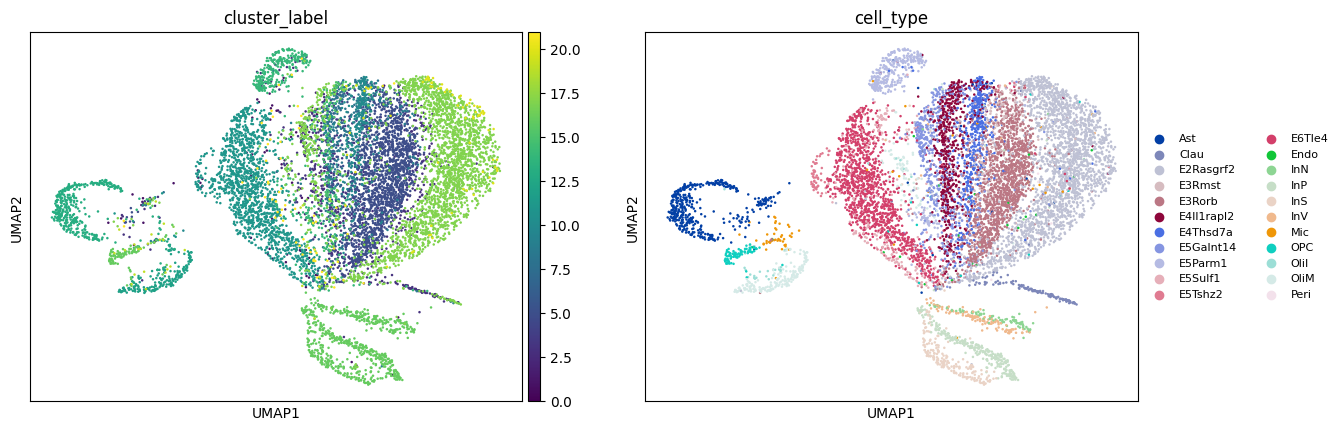

In [28]:
# 从文本文件加载聚类结果, 从h5ad文件读取数据
cluster_labels = np.loadtxt(result_path2, dtype=int)  
adata = ad.read_h5ad(h5ad_path2)
# 添加聚类标签到 AnnData 对象
adata.obs['cluster_label'] = cluster_labels

# 过滤掉表达量低于 3 个细胞的基因
sc.pp.filter_genes(adata, min_cells=3)
# 对数据进行 log1p 转换
sc.pp.log1p(adata)
# 对数据进行缩放，限定最大值为 10
sc.pp.scale(adata, max_value=10)
# 进行 PCA 分析，选择前 30 个主成分
sc.pp.pca(adata, n_comps=30, svd_solver='arpack')
# 计算邻域关系，使用 PCA 结果
sc.pp.neighbors(adata, use_rep='X_pca')
# 计算 UMAP
sc.tl.umap(adata)
# # 使用 Leiden 算法进行社区检测，分辨率为 1.5
# sc.tl.leiden(adata, resolution=1.5)
# 绘制 UMAP 图，颜色表示 Leiden 簇和自定义的聚类标签 'cluster_label'
sc.pl.umap(adata, color=["cluster_label", 'cell_type'], legend_fontsize=8)


由上述可视化结果可知，能看出和正确类型的相似性，说明聚类的效果较好。

## 处理dataset1

In [9]:
# 读取数据集
adata = ad.read_h5ad(h5ad_path1)  # 从h5ad文件读取数据
sc.pp.filter_genes(adata, min_cells=adata.X.shape[0] * 0.05)  # 过滤基因，保留至少占总细胞数5%的基因
sc.pp.log1p(adata)  # 对数据进行log1p变换
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=GENE_NUM)  # 识别高变基因
adata = adata[:, adata.var['highly_variable']]  # 保留高变基因的数据

# 将稀疏矩阵转换为密集矩阵，并保存为CSV文件
x = adata.X.toarray()
np.savetxt(data_path1, x, delimiter=',')

# 将原始数据存储在 adata.raw 中
adata = sc.AnnData(x)
adata.raw = adata.copy()

# 标准化每个细胞的表达量
sc.pp.normalize_per_cell(adata)
# 计算并存储大小因子
adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)

# 类别数目在15到25之间，使用2为步长进行遍历
losss = np.array([])
preds = []
for n_clusters in range(25, 26, 2):
    print("n_clusters", n_clusters)
    pretrain_path1 = 'model/dataset2_pretrain_param%d.pth' % n_clusters
    model_path1 = 'model/dataset2_param%d.pth' % n_clusters

    # 循环进行聚类评估
    for i in range(CYCLE_NUM):
        print("第%d/%d次循环" % (i + 1, CYCLE_NUM))  # 修正此行的格式化字符串

        # 初始化并训练模型
        model = MyModel(
            input_dim=adata.n_vars,
            n_clusters=n_clusters,
            encodeLayer=[256, 64],
            decodeLayer=[64, 256])

        model.pretrain_autoencoder(
            x=adata.X,
            X_raw=adata.raw.X,
            size_factor=adata.obs.size_factors,
            batch_size=1024,
            epochs=PRETRAIN_EPOCH,
            ae_weights=pretrain_path1)

        # 进行最终的聚类和评估
        pred, loss = model.fit(
            X=adata.X,
            X_raw=adata.raw.X,
            sf=adata.obs.size_factors,
            y=None,
            lr=1,
            batch_size=1024,
            num_epochs=TRAIN_EPOCH,
            save_path=model_path1,
            warmup_rate=WARMUP_RATE)

        print("loss={:.4f}".format(loss))
        losss = np.append(losss, loss.cpu())
        preds.append(pred)

best_index = np.argmin(losss)
print('optimal:LOSS= {:.4f}'.format(losss[best_index]))
print('类别个数 : {}'.format(len(set(preds[best_index]))))
pd.DataFrame(preds[best_index]).to_csv(result_path1, index=False, header=False)
print("result save successfully!")


n_clusters 25
第1/3次循环
Pretrain epoch [20/20], ZINB loss:0.4251, Instance loss:0.1159: 100%|██████████| 20/20 [00:46<00:00,  2.30s/it]
#Epoch  50: Total: 1.3451 Clustering Loss: 0.2953 ZINB Loss: 0.4046 C Loss: 0.6453: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]
loss=1.2721
第2/3次循环
Pretrain epoch [20/20], ZINB loss:0.4386, Instance loss:0.1056: 100%|██████████| 20/20 [00:46<00:00,  2.35s/it]
#Epoch  50: Total: 1.3749 Clustering Loss: 0.3280 ZINB Loss: 0.4053 C Loss: 0.6417: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]
loss=1.2923
第3/3次循环
Pretrain epoch [20/20], ZINB loss:0.4268, Instance loss:0.0962: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]
#Epoch  50: Total: 1.2559 Clustering Loss: 0.2133 ZINB Loss: 0.4055 C Loss: 0.6371: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]
loss=1.2559
optimal:LOSS= 1.2559
类别个数 : 18
result save successfully!
